In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PokedexDataset import Pokemon

In [41]:
lr = 1e-3
batch_size = 16


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Obtain and Split Dataset
     
dataset = Pokemon(csv_file= 'Pokemon.csv' , root_dir= 'pokemon', transform= transform)
train_set ,val_set ,test_set = torch.utils.data.random_split(dataset, [669,331,331]) 

#Train , Validation, and Test Loaders

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=0)


valid_loader =  torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers= 0)


test_loader =  torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True, num_workers= 0)

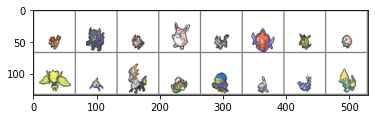

In [55]:
#Helper Function
def imshow(img):
    img = img / 2 + 0.5 
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [43]:
class PokemonAutoEncoder(nn.Module): #N , 3 , 64 , 64
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16 , 3, stride = 2 , padding = 1), #N , 16 , 32 , 32
            nn.ELU(),
            nn.Conv2d(16, 32 , 3, stride = 2, padding= 1), #N , 32 , 16 , 16
            nn.ELU(),
            nn.Conv2d(32 , 64 , 3 , stride= 2 , padding=1),#N , 64 , 8, 8
            nn.ELU(),
            nn.Conv2d(64,128,3,stride = 2, padding = 1), #N , 128, 4, 4
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64 , 3, stride=2, padding= 1, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32 , 3, stride=2, padding= 1, output_padding=1),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16 , 3 , stride = 2, padding= 1, output_padding= 1),
            nn.ELU(),
            nn.ConvTranspose2d(16, 3 , 3 , stride= 2 , padding= 1, output_padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [44]:
#Kaiming Initialization Function

def weights_init(m):
    if isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
    if isinstance(m,nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)

In [45]:
#Load PokemonAutoEncoder Model w/ Hyperparameters

model = PokemonAutoEncoder()
model = model.double()
model.apply(weights_init)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay= 1e-5 )

In [46]:
#Training Network

num_epochs = 150
outputs = []

validation_loss = []
training_loss = []

for epoch in range(num_epochs):
    train_loss = 0.0
    #Training Set
    for (img, _ ) in train_loader :
        recon = model(img)
        loss = criterion(recon,img)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    outputs.append((epoch,img,recon))

    model.eval()
    valid_loss = 0.0
    #Validation Set
    for (img, _) in valid_loader:
        val_recon = model(img)
        val_loss = criterion(val_recon, img)
        valid_loss += val_loss.item()


    validation_loss.append(valid_loss / len(valid_loader))
    training_loss.append(train_loss / len(train_loader))

    #Traning and Validation Loss
    print(f'Epoch :{epoch + 1} , Train Loss : {(train_loss/len(train_loader)) : .4f} \t \t Validation Loss : {(valid_loss / len(valid_loader)) : .4f}')





print('Finished Training')

PATH = './Pokedex.pth'
torch.save(model.state_dict(), PATH)

Epoch :1 , Train Loss :  0.3910 	 	 Validation Loss :  0.1114
Epoch :2 , Train Loss :  0.0885 	 	 Validation Loss :  0.0777
Epoch :3 , Train Loss :  0.0670 	 	 Validation Loss :  0.0633
Epoch :4 , Train Loss :  0.0553 	 	 Validation Loss :  0.0542
Epoch :5 , Train Loss :  0.0483 	 	 Validation Loss :  0.0486
Epoch :6 , Train Loss :  0.0439 	 	 Validation Loss :  0.0451
Epoch :7 , Train Loss :  0.0409 	 	 Validation Loss :  0.0425
Epoch :8 , Train Loss :  0.0385 	 	 Validation Loss :  0.0404
Epoch :9 , Train Loss :  0.0366 	 	 Validation Loss :  0.0386
Epoch :10 , Train Loss :  0.0350 	 	 Validation Loss :  0.0372
Epoch :11 , Train Loss :  0.0335 	 	 Validation Loss :  0.0357
Epoch :12 , Train Loss :  0.0322 	 	 Validation Loss :  0.0346
Epoch :13 , Train Loss :  0.0311 	 	 Validation Loss :  0.0337
Epoch :14 , Train Loss :  0.0300 	 	 Validation Loss :  0.0326
Epoch :15 , Train Loss :  0.0291 	 	 Validation Loss :  0.0319
Epoch :16 , Train Loss :  0.0281 	 	 Validation Loss :  0.0310
E

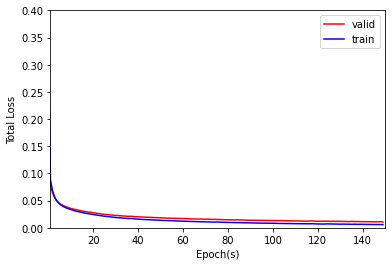

In [47]:
#Graph Showing Training and Validation Loss

from cProfile import label

lst = list(range(1,11))

plt.plot(validation_loss, label = 'valid', color = 'r')
plt.plot(training_loss, label = 'train', color = 'b')
plt.xlabel("Epoch(s)")
plt.ylabel("Total Loss")
plt.xlim(1, 150)
plt.ylim(0, 0.4)

plt.legend()
plt.show()

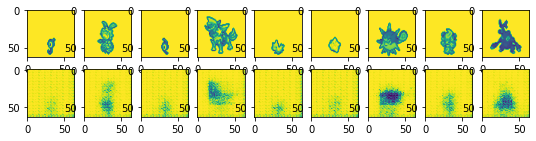

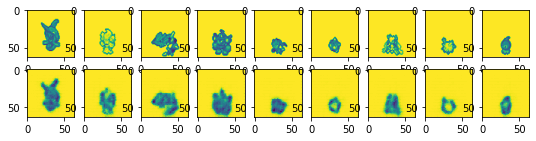

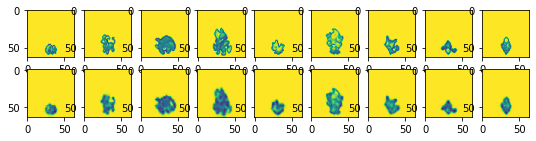

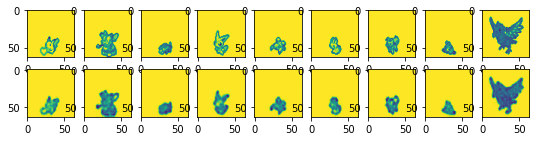

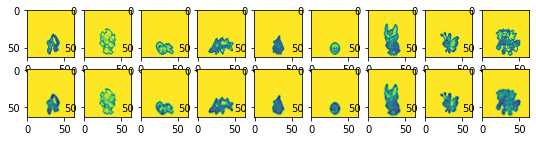

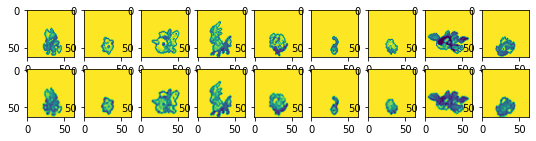

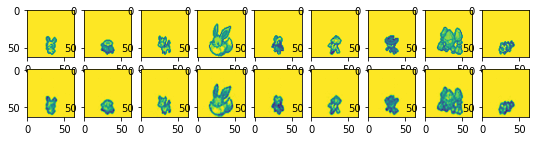

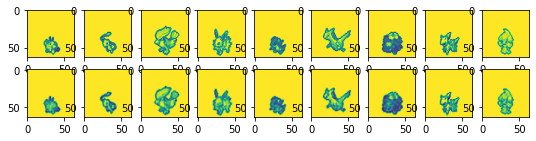

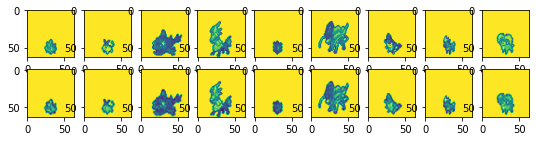

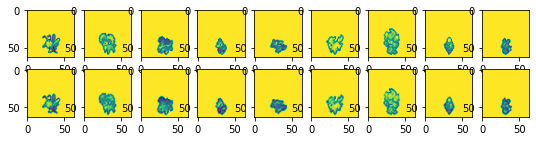

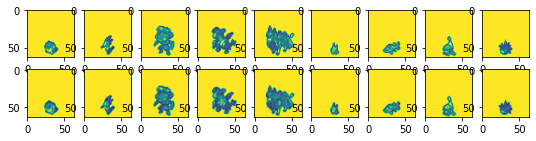

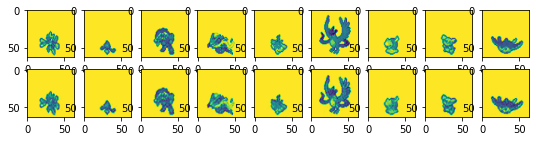

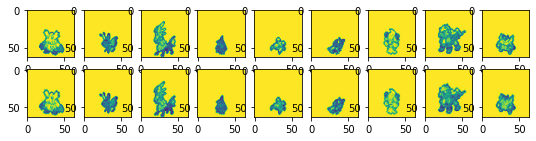

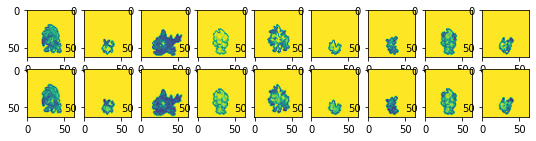

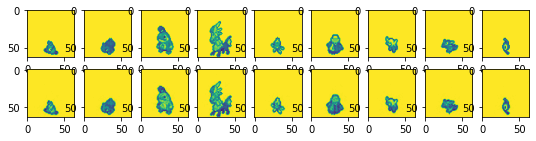

In [48]:
#Results of Training Overtime with the Training set

for k in range(0, num_epochs,10): #Every 10th Epoch
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

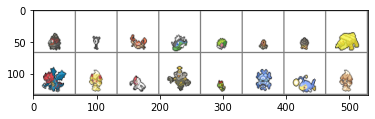

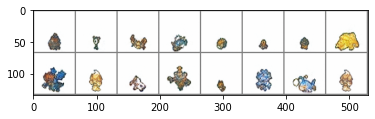

In [54]:
#Loading and Testing Data on the Test set

model = PokemonAutoEncoder()
model.double()
model.load_state_dict(torch.load(PATH))


dataiter = iter(test_loader)

images, labels = dataiter.next()

output = model(images)


output = output.view(16, 3 , 64 , 64)

output = output.detach()


imshow(torchvision.utils.make_grid(images))

imshow(torchvision.utils.make_grid(output))